<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/03%20-%20Advanced%20experiments%20design/06_multiple_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import itertools as it

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.7/935.7 kB 9.5 MB/s eta 0:00:00


In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

Вычитаем данные о том, как различные уникальные пользователи (passport_id) покупали (метка sign = -1 и amount < 0) услуги со своего балланса (balance_consumption) в указанный период ('2022-01-01' - '2022-02-28')

In [ ]:
#
sql = """
SELECT
  la.passport_id AS passport_id,
  SUM(
    CASE
      WHEN sign = -1
      AND amount < 0 THEN balance_consumption
      ELSE 0
    END
  ) AS money
FROM
  live_adverts la
LEFT JOIN user_transactions ut ON CAST(la.advert_id AS String) = CAST(ut.advert_id AS String)
  AND la.passport_id = ut.passport_id
  AND la.execution_date = ut.payment_date
WHERE
  la.execution_date BETWEEN '2022-01-01'
  AND '2022-02-28'
GROUP BY
  la.passport_id
"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
print("Количество уникальных пользователей %s" % data.passport_id.nunique())
data.head()

Количество уникальных пользователей 398500


,passport_id,money
0,133483447,0
1,135714633,0
2,134052529,175
3,138492170,430
4,142968570,215


Загрузим данные о том, как пользователи были рабиты на группы (A B C D)

In [ ]:
data_split = pd.read_csv("user_groups.csv", index_col="Unnamed: 0")

In [ ]:
print("Количество уникальных пользователей %s" % data_split.passport_id.nunique())
data_split.head()

Количество уникальных пользователей 398500


,passport_id,group
0,123463044,D
1,123463046,A
2,123463061,C
3,123463062,C
4,123463070,D


## Задание 1 (1/2) ##
Выгрузите данные по пользователям, суммарную выручку за период теста 2022-01-01 – 2022-02-28, а также файл с разметкой (файл с указанием к какой группе относился тот или иной пользователь user_groups.csv). Найдите среднее значение выручки.

Введите средний ARPU (money) на пользователя по всему датасету в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

Полезно заменить NAN нулями, так ARPU будет считаться корректнее

In [ ]:
print(f"ARPU (money) на пользователя по всему датасету =  {data.money.mean():.1f}" )

ARPU (money) на пользователя по всему датасету =  564.4


## Задание 1 (2/2) ##
Расположите средние ARPU по группам эксперимента в порядке возрастания.

In [ ]:
data_grouped = data.merge(data_split, on="passport_id")
data_grouped[['group', 'money']].groupby("group").mean().sort_values(by="money")

,money
group,
B,527.843047
C,554.053060
D,587.104361
A,588.716362


## Задание 2 ##
Оцените p-value значения с помощью стат. теста t-test для проверки гипотез между A-B, A-C, A-D, B-C, B-D, C-D.

In [ ]:
import itertools as it

In [ ]:
pvals = dict()
for g in it.combinations(sorted(data_grouped.group.unique()), 2):
  g = "".join(g)
  pvals[g] = ttest_ind(data_grouped.query("group == @g[0]").money,
                                              data_grouped.query("group == @g[1]").money, alternative='two-sided').pvalue

In [ ]:
for k, v in pvals.items():
    print(f'{k} p-vlaue: {v:.4f}')

AB p-vlaue: 0.0087
AC p-vlaue: 0.1466
AD p-vlaue: 0.9545
BC p-vlaue: 0.1061
BD p-vlaue: 0.0073
CD p-vlaue: 0.1472


## Задание 4 (1/4) ##
Воспользуйтесь методами поправки Шидака, Холма-Бонферрони. Какие скорректированные пороговые alpha (новый уровень стат. значимости) получатся?

Введите новый скорректированный альфа для метода Шидака в поле ниже с точностью до четырех знаков в десятичной части.

In [ ]:
bonferroni_alpha = multipletests(pvals=list(pvals.values()), alpha=.05, method='bonferroni')[2]
bonferroni_alpha

0.008512444610847103

In [ ]:
Sidak_alpha = multipletests(pvals=list(pvals.values()), alpha=.05, method='sidak')[2]
Sidak_alpha

0.008512444610847103

In [ ]:
holm_bonferroni_alpha = multipletests(pvals=list(pvals.values()), alpha=.05, method='holm')[2]
holm_bonferroni_alpha

0.008512444610847103

In [ ]:
print(f"Новый скорректированный альфа для метода Шидака {Sidak_alpha:.4f}")

Новый скорректированный альфа для метода Шидака 0.0085


## Задание 4 (2/4) ##
Какой будет новая скорректированная альфа для метода Холма-Бонферрони для пары A-B?

Введите ответ в поле ниже с точностью до четырех знаков в десятичной части

In [ ]:
data_hyp = pd.DataFrame(sorted(pvals.items(), key=lambda x: x[1]), columns=['group', 'p-value'])

In [ ]:
alpha = 0.05
num_experiments = len(pvals)
hb_alpha = [alpha / (num_experiments - i) for i in range(num_experiments)]

In [ ]:
data_hyp = data_hyp.join(pd.Series(hb_alpha, name='hb_alpha'))
data_hyp['H0 rejected_hb'] = data_hyp['p-value'] < data_hyp['hb_alpha']
data_hyp

,group,p-value,hb_alpha,H0 rejected_hb
0,BD,0.007302,0.008333,True
1,AB,0.008709,0.010000,True
2,BC,0.106108,0.012500,False
3,AC,0.146649,0.016667,False
4,CD,0.147231,0.025000,False
5,AD,0.954498,0.050000,False


## Задание 5 (1/2) ##
Какие гипотезы смогли преодолеть критический уровень статистической значимости с учетом скорректированных значений по методу Шидака?

In [ ]:
data_hyp['sidak_alpha'] = Sidak_alpha
data_hyp['H0 rejected_sidak'] = data_hyp['p-value'] < data_hyp['sidak_alpha']
data_hyp

,group,p-value,hb_alpha,H0 rejected_hb,sidak_alpha,H0 rejected_sidak
0,BD,0.007302,0.008333,True,0.008512,True
1,AB,0.008709,0.010000,True,0.008512,False
2,BC,0.106108,0.012500,False,0.008512,False
3,AC,0.146649,0.016667,False,0.008512,False
4,CD,0.147231,0.025000,False,0.008512,False
5,AD,0.954498,0.050000,False,0.008512,False


## Задание 6 (1/2) ##
Посчитайте через симуляцию размер выборки с коррекцией Холма-Бонферрони (FWER для альфа= 0.05) такую, чтобы мощность нахождения всех эффектов в размере 20 относительных процентов в парах A-B, A-C, A-D была гарантирована на уровне 0.8. Т.е. если из трех реальных эффектов хотя бы одна гипотеза ложно пропущена, то считается, что мы совершили ошибку второго рода. Т.е. нужно вернуть FWER ошибки второго рода beta к 0.2.

Больше условий для проведения симуляции будет дано на следующем степе.

Перед запуском симуляции определите примерный размер выборки, с которого стоит начинать перебор. Для этого округлите нужный размер выборки для стандартного двустороннего t-test с заданными уровнями альфа, бета и MDE.

Округлите стартовый размер выборки до 10 тыс. в ближайшую сторону: round(sample_size, -4)

In [ ]:
data_a = data_grouped.query("group == 'A'").money

In [ ]:
def multi_tt_sample_size_calc(test_data, n_comparisons=3, iters=200, alpha=0.05, power=0.8, effect_size=0.2, sample_size=None, step=1000):

    def holm_test(pvals:list, alpha:float) -> bool:
        pvals = np.array(pvals)
        n = len(pvals)
        alphas = np.array([alpha / (n - i) for i in range(n)])
        return (pvals < alphas).all()

    np.random.seed(1)
    while True:
        sample_size = sample_size or len(test_data)
        pvalues = list()
        hypotesis_accepted = list()
        non_corrected_hypotesis_accepted = list()
        for j in range(iters):
            samples = np.append(np.random.choice(test_data, size=(1, sample_size)),
                                np.random.choice(test_data * (1 + effect_size), size=(n_comparisons, sample_size)),
                                axis=0)

            pvalues.append([ttest_ind(samples[0], i, alternative='two-sided').pvalue for i in samples[1:]])
            hypotesis_accepted.append(holm_test(sorted(pvalues[-1]), alpha))
            non_corrected_hypotesis_accepted.append(all(np.array(pvalues[-1]) < alpha))
        if np.mean(hypotesis_accepted) > power + 0.05:
            print("-" * 10)
            print(f"sample_size = {sample_size:_}, power = {np.mean(non_corrected_hypotesis_accepted)} / {np.mean(hypotesis_accepted)}")
            return sample_size
        print(f"sample_size = {sample_size:_}, power = {np.mean(non_corrected_hypotesis_accepted)} / {np.mean(hypotesis_accepted)}")
        sample_size += step


In [ ]:
np.random.seed(1)
multi_tt_sample_size_calc(data_a, sample_size=50_000)

sample_size = 50_000, power = 0.655 / 0.615
sample_size = 51_000, power = 0.655 / 0.63
sample_size = 52_000, power = 0.53 / 0.5
sample_size = 53_000, power = 0.57 / 0.555
sample_size = 54_000, power = 0.665 / 0.65
sample_size = 55_000, power = 0.675 / 0.67
sample_size = 56_000, power = 0.65 / 0.62
sample_size = 57_000, power = 0.705 / 0.695
sample_size = 58_000, power = 0.665 / 0.65
sample_size = 59_000, power = 0.68 / 0.66
sample_size = 60_000, power = 0.695 / 0.68
sample_size = 61_000, power = 0.735 / 0.685
sample_size = 62_000, power = 0.74 / 0.73
sample_size = 63_000, power = 0.73 / 0.71
sample_size = 64_000, power = 0.72 / 0.695
sample_size = 65_000, power = 0.705 / 0.685
sample_size = 66_000, power = 0.75 / 0.73
sample_size = 67_000, power = 0.79 / 0.765
sample_size = 68_000, power = 0.84 / 0.815
sample_size = 69_000, power = 0.76 / 0.745
sample_size = 70_000, power = 0.84 / 0.82
sample_size = 71_000, power = 0.75 / 0.74
sample_size = 72_000, power = 0.825 / 0.81
sample_size = 73

80000

In [ ]:
from statsmodels.stats.power import tt_ind_solve_power

In [ ]:
cohen_d = data_a.mean() * 0.2 / data_a.std()
sample_size = round(tt_ind_solve_power(effect_size=cohen_d, nobs1 = None, alpha = 0.05, power=0.8, alternative='two-sided'), -4)

In [ ]:
print("Начальный размер выборки %s" % sample_size)

Начальный размер выборки 50000.0


In [ ]:
def find_multi_tt_sample_size_2(hist_data, n_sim, sample_size_start, rel_effect, sample_size_step, power_set, plot = True, alpha = 0.05, method = 'bonferroni'):
    '''
    hist_data - метрика по историческим данным, которую мы используем в тесте
    n_sim - кол-во итерраций симуляции для каждого размера выборки
    sample_size_start - с какого значения выборки начинаем перебор
    rel_effect - какой относительный эффект, MDE хотим проверить
    sample_size_step - шаг приращения размера выборки
    power_set - какой мощности хотим достичь
    plot - Отрисовываем ли график
    alpha - Уровень стат.значимости
    method - метод коррекции множественных сравнений
        - `bonferroni` : one-step correction
        - `sidak` : one-step correction
        - `holm-sidak` : step down method using Sidak adjustments
        - `holm` : step-down method using Bonferroni adjustments
        - `simes-hochberg` : step-up method  (independent)
        - `hommel` : closed method based on Simes tests (non-negative)
        - `fdr_bh` : Benjamini/Hochberg  (non-negative)
        - `fdr_by` : Benjamini/Yekutieli (negative)
        - `fdr_tsbh` : two stage fdr correction (non-negative)
        - `fdr_tsbky` : two stage fdr correction (non-negative)
    '''

    sample_size_list = []
    power_value_list = []
    power_value_corrected_list = []

    while True:
        p_value_list = []
        for i in range(n_sim):
            group_a = np.random.choice(hist_data, size = sample_size_start)
            group_b = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            group_c = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            group_d = np.random.choice(hist_data*(1+rel_effect), size = sample_size_start)
            ab_t_stat, ab_p_value = ttest_ind(group_a, group_b)
            ac_t_stat, ac_p_value = ttest_ind(group_a, group_c)
            ad_t_stat, ad_p_value = ttest_ind(group_a, group_d)
            p_value_list.append((ab_p_value, ac_p_value, ad_p_value))

        tp = np.logical_and.reduce([np.array(p_value_list)[:, 0] < alpha, np.array(p_value_list)[:, 1] < alpha, np.array(p_value_list)[:, 2] < alpha])
        # используем logical_and.reduce т.к. сравниваем здесь три булевых значения. Стандартный logical_and так сравнить не может

        #скорректируем p-value через метод
        hypothesys = []
        for i in range(len(p_value_list)):
            hypothesys.append(multipletests(p_value_list[i], alpha = alpha, method = method)[0])
        tp_corrected =  np.logical_and.reduce([np.array(hypothesys)[:,0], np.array(hypothesys)[:,1], np.array(hypothesys)[:,2]])

        power_value = tp.mean()
        power_value_corrected = tp_corrected.mean()
        power_value_list.append(power_value)
        power_value_corrected_list.append(power_value_corrected)
        sample_size_list.append(sample_size_start)
        print(sample_size_start, power_value, power_value_corrected)
        if power_value_corrected > power_set + 0.05:
            break
        else:
            sample_size_start += sample_size_step

    # рассчитаем итоговые значения размеров выборки
    non_corrected_power = power_value_list[np.argmax(np.array(power_value_list) >= power_set)]
    corrected_power = power_value_corrected_list[np.argmax(np.array(power_value_corrected_list) >= power_set)]
    non_corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_list) >= power_set)]
    corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_corrected_list) >= power_set)]

    #отрисовываем график
    if plot: # отрисовываем график набора мощности
        plt.figure(figsize = (16, 8))
        sns.lineplot(x= sample_size_list, y = power_value_list, label = 'Non corrected power')
        sns.lineplot(x= sample_size_list, y = power_value_corrected_list, label = 'Corrected power')
        plt.axhline(y = 0.8, linestyle  = '--', color = 'red')
        plt.axvline(x = non_corrected_sample_size, linestyle  = '--', color = 'red')
        plt.axvline(x = corrected_sample_size, linestyle  = '--', color = 'blue')

        plt.text(x = round(non_corrected_sample_size * 0.97),
                 y = np.quantile(power_value_list, 0.3),
                 s = 'Размер выборки без коррекции ~ {}'.format(non_corrected_sample_size),
                rotation = 'vertical',
                color = 'red')
        plt.text(x = round(corrected_sample_size * 0.97),
                 y = np.quantile(power_value_list, 0.3),
                 s = 'Размер выборки c коррекцией ~ {}'.format(corrected_sample_size),
                rotation = 'vertical',
                color = 'blue')

    return_object = {'non_corrected sample_size': non_corrected_sample_size,
                     'corrected sample size': corrected_sample_size,
                    'non corrected power':non_corrected_power,
                    'corrected power':corrected_power }

    return(return_object)

In [ ]:
import time

50000 0.655 0.615
51000 0.655 0.63
52000 0.53 0.5
53000 0.57 0.555
54000 0.665 0.65
55000 0.675 0.67
56000 0.65 0.62
57000 0.705 0.695
58000 0.665 0.65
59000 0.68 0.66
60000 0.695 0.68
61000 0.735 0.685
62000 0.74 0.73
63000 0.73 0.71
64000 0.72 0.695
65000 0.705 0.685
66000 0.75 0.73
67000 0.79 0.765
68000 0.84 0.815
69000 0.76 0.745
70000 0.84 0.82
71000 0.75 0.74
72000 0.825 0.81
73000 0.805 0.795
74000 0.815 0.815
75000 0.815 0.795
76000 0.83 0.83
77000 0.815 0.79
78000 0.83 0.81
79000 0.81 0.8
80000 0.9 0.89
Execution time: 706.6045091152191


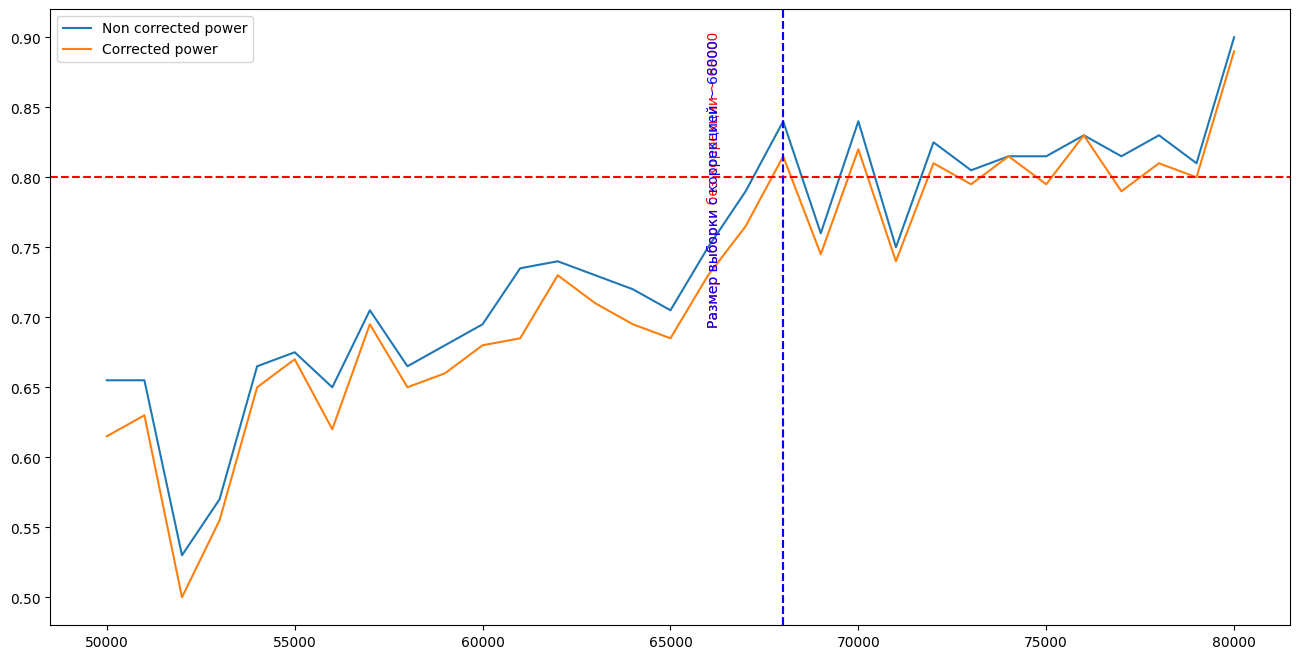

In [ ]:

start_time = time.time()
np.random.seed(1)
object = find_multi_tt_sample_size_2(data_a, 200, 50_000, 0.2, 1000, 0.8, plot = True, method = 'holm')
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time}")
